# Prezentacja danych datasetu SWaT / wykorzystanie autoencodera

### Wczytanie danych

In [4]:
import pandas as pd

df1 = pd.read_csv('SWaT_Dataset_Attack_v0.csv', sep=';', decimal=',', low_memory=False)

In [5]:
df2 = pd.read_csv('SWaT_Dataset_Normal_v1.csv', decimal=',')

In [6]:
print(df1.shape)
print(df2.shape)

attack_count1 = (df1[df1.columns[-1]] == "Attack").sum()
print(f'Liczba wierszy z "Attack" w ostatniej kolumnie: {attack_count1}')
attack_count2 = (df2[df2.columns[-1]] == "Attack").sum()
print(f'Liczba wierszy z "Attack" w ostatniej kolumnie: {attack_count2}')

(449919, 53)
(495000, 53)
Liczba wierszy z "Attack" w ostatniej kolumnie: 54584
Liczba wierszy z "Attack" w ostatniej kolumnie: 0


In [7]:
df1.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


In [8]:
df2.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:30:00 PM,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
1,22/12/2015 4:30:01 PM,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2,22/12/2015 4:30:02 PM,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
3,22/12/2015 4:30:03 PM,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
4,22/12/2015 4:30:04 PM,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal


### Dane z czujników na wykresie

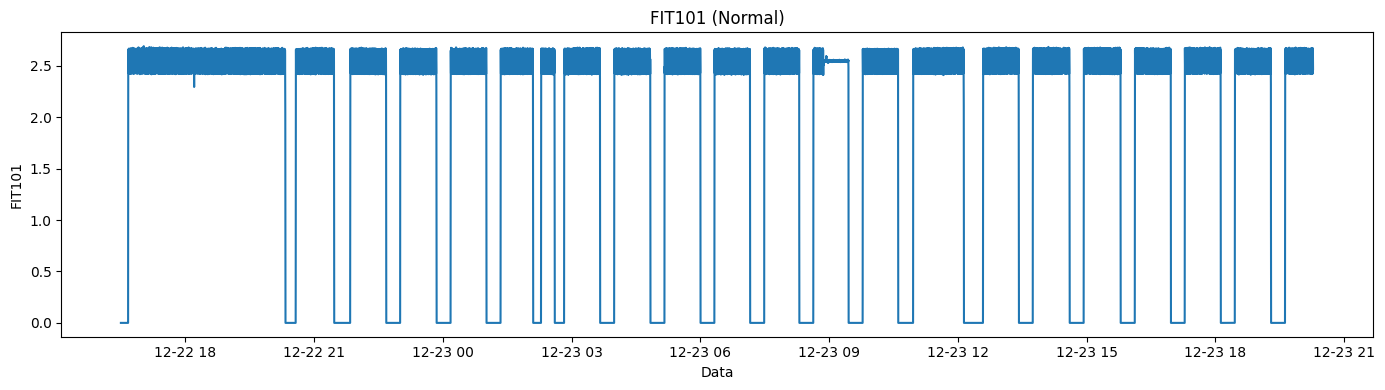

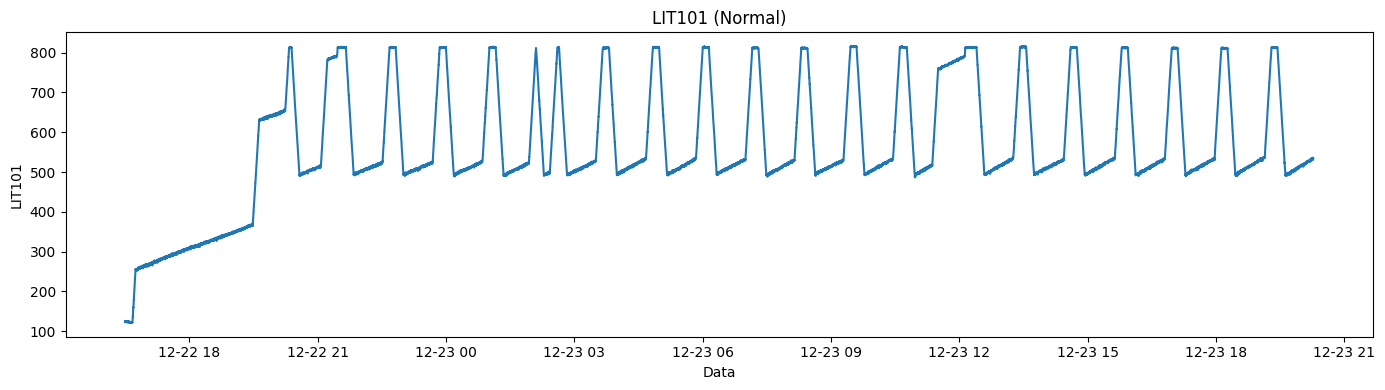

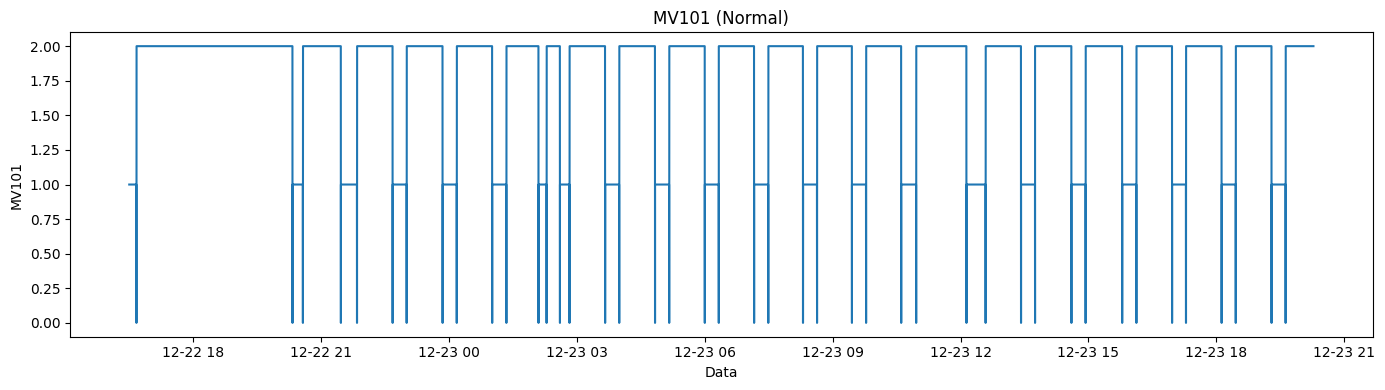

In [9]:
import matplotlib.pyplot as plt

df2_small = df2.head(100000).copy()

# Format daty: dd/mm/yyyy h:mm:ss AM/PM
df2_small['Timestamp'] = pd.to_datetime(
    df2_small['Timestamp'].str.strip(),
    format='%d/%m/%Y %I:%M:%S %p',
    errors='coerce'
)

# Lista wszystkich czujników (bez kolumny Timestamp i etykiety)
sensor_columns = [col for col in df2_small.columns if col not in ['Timestamp', 'Normal/Attack']]

num_sensors_to_plot = 3 # Liczba czujników do wyświetlenia

for sensor in sensor_columns[:num_sensors_to_plot]:
    plt.figure(figsize=(14, 4))
    plt.plot(df2_small['Timestamp'], df2_small[sensor])
    plt.title(f'{sensor} (Normal)')
    plt.ylabel(sensor)
    plt.xlabel('Data')
    plt.tight_layout()
    plt.show()

### Czy GPU dostępne?

In [10]:
import torch

if torch.cuda.is_available():
    print("GPU is available :)")
    device = torch.device("cuda")
else:
    print("GPU is NOT available, using CPU. :( ")
    device = torch.device("cpu")

GPU is available :)


In [11]:
print(len(sensor_columns))

51


### Definicja autoencodera

In [12]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(len(sensor_columns), 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, len(sensor_columns)),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    

### Normalizacja danych

In [13]:
from sklearn.preprocessing import MinMaxScaler
import torch

sensor_columns = [col for col in df2.columns if col not in ['Timestamp', 'Normal/Attack']]
df2_sensors = df2[sensor_columns].copy()

# Normalizacja danych do zakresu [0, 1]
scaler = MinMaxScaler()
df2_normalized = scaler.fit_transform(df2_sensors)

X = torch.tensor(df2_normalized, dtype=torch.float32)

### Nauka

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# DataLoader
batch_size = 32
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Inicjalizacja modelu / wykorzystanie GPU
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

# Pętla treningowa
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for batch in loader:
        x_batch = batch[0].to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.6f}")

Epoch 1/10, Loss: 0.003157
Epoch 2/10, Loss: 0.000835
Epoch 3/10, Loss: 0.000551
Epoch 4/10, Loss: 0.000420
Epoch 5/10, Loss: 0.000345
Epoch 6/10, Loss: 0.000303
Epoch 7/10, Loss: 0.000271
Epoch 8/10, Loss: 0.000242
Epoch 9/10, Loss: 0.000221
Epoch 10/10, Loss: 0.000203


### Zapis modelu do pliku

In [ ]:
torch.save(model.state_dict(), "autoencoder_swat.pth")
print("Model został zapisany do 'autoencoder_swat.pth'")

Model został zapisany do 'autoencoder_swat.pth'


### Wczytanie modelu z pliku

In [14]:
import torch
model = AE().to(device)
model.load_state_dict(torch.load("autoencoder_swat.pth", map_location=device))

<All keys matched successfully>

### Wyniki

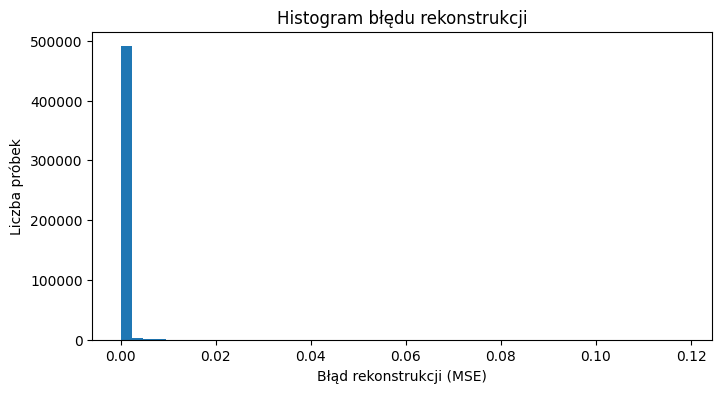

In [ ]:
import torch

# Rekonstrukcja na całym zbiorze
model.eval()
with torch.no_grad():
    X_recon = model(X.to(device)).cpu().numpy()

# Błąd rekonstrukcji (MSE dla każdego wiersza)
import numpy as np
recon_error = np.mean((X.numpy() - X_recon) ** 2, axis=1)

# Histogram błędu rekonstrukcji
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(recon_error, bins=50)
plt.title("Histogram błędu rekonstrukcji")
plt.xlabel("Błąd rekonstrukcji (MSE)")
plt.ylabel("Liczba próbek")
plt.show()

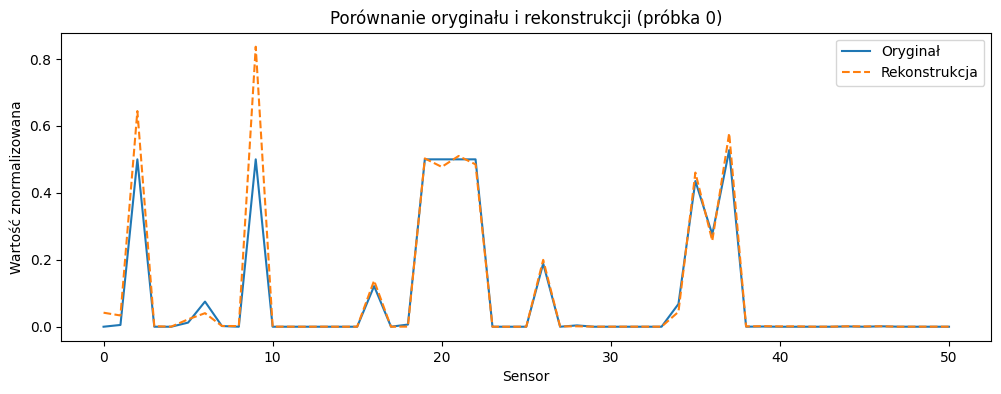

In [16]:
sample_idx = 0  # indeks próbki do wizualizacji
plt.figure(figsize=(12,4))
plt.plot(X[sample_idx].numpy(), label='Oryginał')
plt.plot(X_recon[sample_idx], label='Rekonstrukcja', linestyle='dashed')
plt.title(f'Porównanie oryginału i rekonstrukcji (próbka {sample_idx})')
plt.xlabel('Sensor')
plt.ylabel('Wartość znormalizowana')
plt.legend()
plt.show()

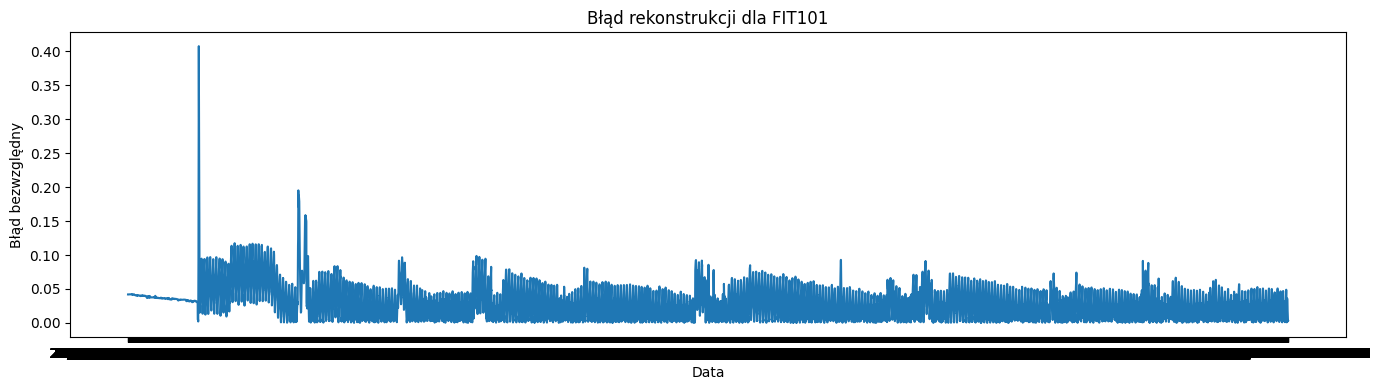

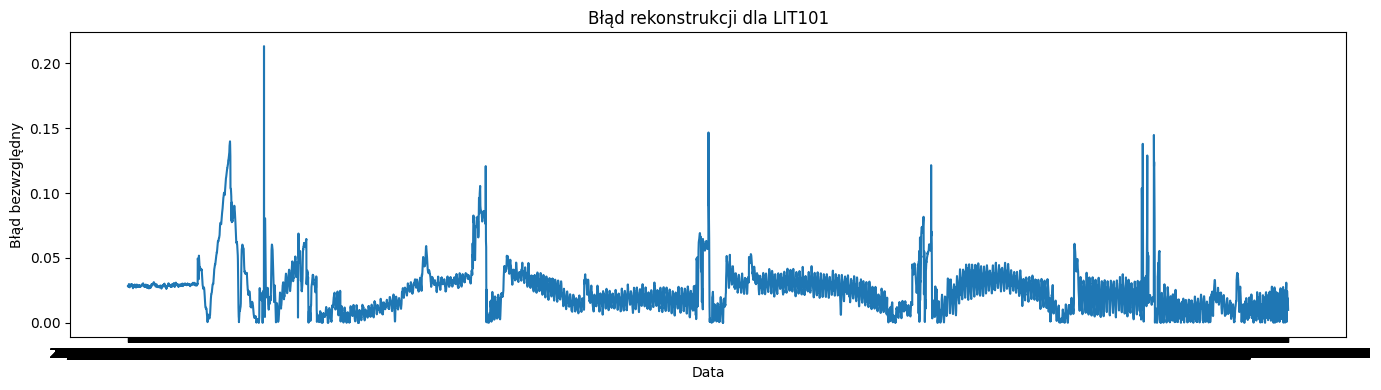

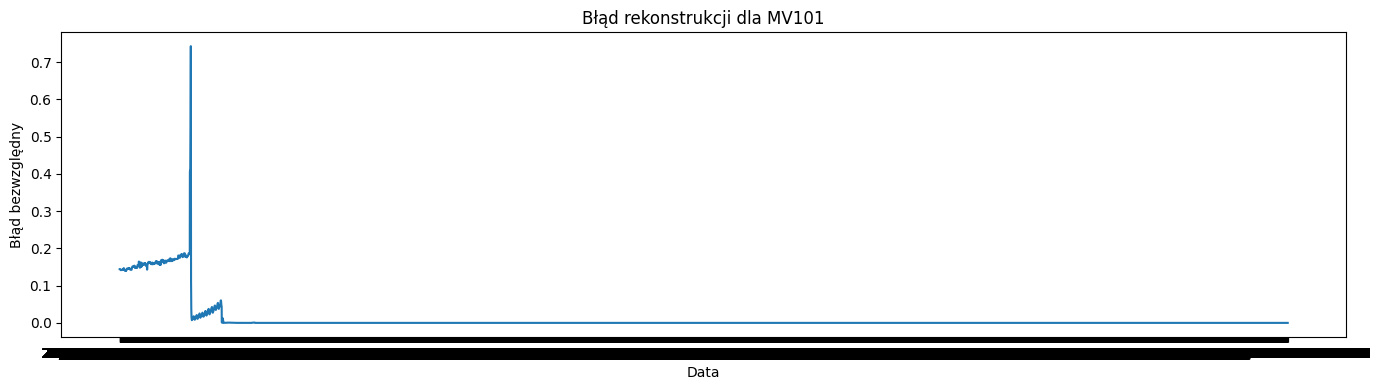

In [17]:
import matplotlib.pyplot as plt
import numpy as np

samples = 10000  # liczba próbek do wizualizacji

X_np = X.cpu().numpy()[:samples] if hasattr(X, 'cpu') else X.numpy()[:samples]
X_recon_10k = X_recon[:samples]
timestamps = df2['Timestamp'][:samples] if 'Timestamp' in df2.columns else np.arange(samples)

num_sensors_to_plot = 3  # lub dowolna liczba sensorów do wizualizacji

for sensor in sensor_columns[:num_sensors_to_plot]:
    idx = sensor_columns.index(sensor)
    error = np.abs(X_np[:, idx] - X_recon_10k[:, idx])
    plt.figure(figsize=(14, 4))
    plt.plot(timestamps, error)
    plt.title(f'Błąd rekonstrukcji dla {sensor}') 
    plt.ylabel('Błąd bezwzględny')
    plt.xlabel('Data' if 'Timestamp' in df2.columns else 'Indeks próbki')
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import torch

sensor_columns = [col for col in df1.columns if col not in ['Timestamp', 'Normal/Attack']]
df1_sensors = df1[sensor_columns].copy()

df1_normalized = scaler.transform(df1_sensors)
X1 = torch.tensor(df1_normalized, dtype=torch.float32)

# Przepuszczenie danych z df1 przez autoenkoder
model.eval()
with torch.no_grad():
    X1_recon = model(X1.to(device)).cpu().numpy()

# Błąd rekonstrukcji dla każdej próbki
recon_error1 = np.mean((X1.numpy() - X1_recon) ** 2, axis=1)

# Próg detekcji anomalii (percentyl)
threshold = np.percentile(recon_error, 99)  # recon_error z treningu na df2

predicted_anomaly = recon_error1 > threshold

# Porównanie z etykietami z df1
true_anomaly = df1['Normal/Attack'].values == "Attack"

# Skuteczność modelu
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion matrix:")
print(confusion_matrix(true_anomaly, predicted_anomaly))
print("\nClassification report:")
print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Attack"]))

Confusion matrix:
[[104820 290515]
 [  2871  51713]]

Classification report:
              precision    recall  f1-score   support

      Normal       0.97      0.27      0.42    395335
      Attack       0.15      0.95      0.26     54584

    accuracy                           0.35    449919
   macro avg       0.56      0.61      0.34    449919
weighted avg       0.87      0.35      0.40    449919

